# Arabidopsis thaliana effective graph

> A.J. Gates, R.B. Correia, X. Wang, & L.M. Rocha [2021]. "The effective graph reveals redundancy, canalization, and control pathways in biochemical regulation and signaling". Proceedings of the National Academy of Sciences (PNAS), 118 (12).

In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import graphviz
import math
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Cana
from cana.datasets.bio import THALIANA
# Networkx
import networkx as nx

In [2]:
T = THALIANA()

In [3]:
SG = T.structural_graph()
EG = T.effective_graph(threshold=-1)
#
EG0 = T.effective_graph(threshold=0)
EG0p2 = T.effective_graph(threshold=.2)
EG0p4 = T.effective_graph(threshold=.4)

In [4]:
print(EG.nodes(data=True))
print(EG.nodes[9])
print(EG.nodes[8])
print(EG[9][8])
print(EG[8][9])

[(0, {'label': 'AP3'}), (1, {'label': 'UFO'}), (2, {'label': 'FUL'}), (3, {'label': 'FT'}), (4, {'label': 'AP1'}), (5, {'label': 'EMF1'}), (6, {'label': 'LFY'}), (7, {'label': 'AP2'}), (8, {'label': 'WUS'}), (9, {'label': 'AG'}), (10, {'label': 'LUG'}), (11, {'label': 'CLF'}), (12, {'label': 'TFL1'}), (13, {'label': 'PI'}), (14, {'label': 'SEP'})]
{'label': 'AG'}
{'label': 'WUS'}
{'weight': 0.375}
{'weight': 0.10249255952380953}


In [5]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [6]:
pd.options.display.float_format = '{:.2g}'.format
#
df = pd.DataFrame({
        'node':[n.name for n in T.nodes],
        'k':[n.k for n in T.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in T.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in T.nodes],
        'k_r*':[n.input_redundancy(norm=True) for n in T.nodes],
        'k_e*':[n.effective_connectivity(norm=True) for n in T.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    }).set_index('node')
df['k_e^{out} / k^{out}'] = df['k_e^{out}'] / df['k^{out}']
df.sort_values('k',ascending=False,inplace=True)
display(df)

ZeroDivisionError: float division by zero

In [ ]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

IG: Number of nodes: 15
IG: Number nodes with a self-loop: 5
IG: Number of input nodes: 3
IG: Number of input nodes with self-loop: 1
--
EG: Number of nodes: 15
EG: Number nodes with a self-loop: 5
EG: Number of input nodes: 3
EG: Number of input nodes with self-loop: 1
--
EG (0.2): Number of nodes: 15
EG (0.2): Number nodes with a self-loop: 3
EG (0.2): Number of input nodes: 3
EG (0.2): Number of input nodes with self-loop: 1
--
EG (0.4): Number of nodes: 15
EG (0.4): Number nodes with a self-loop: 2
EG (0.4): Number of input nodes: 4
EG (0.4): Number of input nodes with self-loop: 2
--


In [ ]:
# Effective edge between WUS and AG
WUS = 8
AG = 9
EG0[WUS][AG]

{'weight': 0.10249255952380942}

In [ ]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(L):
    c = dict(sorted(Counter(L).most_common(), reverse=True)) 
    return c

In [ ]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))    
    print('--')

IG: 1 weakly connected components, sizes {15: 1}
IG: 5 strongly connected components, sizes {10: 1, 2: 1, 1: 3}
--
EG: 1 weakly connected components, sizes {15: 1}
EG: 6 strongly connected components, sizes {9: 1, 2: 1, 1: 4}
--
EG (0.2): 3 weakly connected components, sizes {13: 1, 1: 2}
EG (0.2): 8 strongly connected components, sizes {7: 1, 2: 1, 1: 6}
--
EG (0.4): 4 weakly connected components, sizes {12: 1, 1: 3}
EG (0.4): 10 strongly connected components, sizes {6: 1, 1: 9}
--


In [ ]:
dict_effconn = {nid: node.effective_connectivity(norm=False) 
    for nid, node in enumerate(T.nodes,start=0) }
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')
nx.set_node_attributes(EG0, dict_effconn, 'effective_connectivity')

In [ ]:
# Node Position for each one of the models
nodes = {d['label']:i for i,d in SG.nodes(data=True)}
att = defaultdict(dict)
#
# Calculates Node position in a circle.
r = 1.8
cx = 2.5
cy = 2.5
for deg,name in zip(range(0,360,30), ['AG', 'AP3', 'PI', 'AP2', 'TFL1', 'FUL', 'AP1', 'FT', 'EMF1', 'LFY', 'SEP', 'WUS']):
    x, y = cx+r*math.cos(math.radians(deg)), cy+r*math.sin(math.radians(deg))
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x,y=y)
# Nodes not on the circle. Manually position them = UFO, LUG, CLF
for name,(x,y) in zip(['UFO','LUG','CLF'], [(5.2,4.0),(5.2,2.0),(5.2,3)]):
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x,y=y)

## Interaction Graph

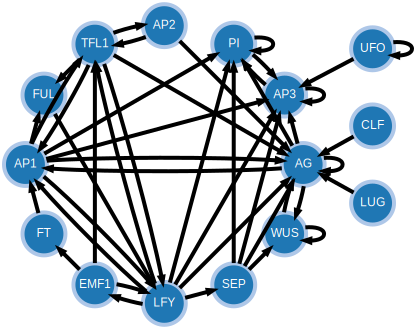

In [ ]:
pSG = graphviz.Digraph(name='Interaction Graph', engine='neato')
pSG.attr('graph', size='6,6', concentrate='false', simplify='false', overlap='scale',splines='false',ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='.60', color='#aec7e8', style='filled', fillcolor='#1f77b4', penwidth='4', fontname='Helvetica', fontcolor='white',fontsize='12')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid,d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    #fillcolor = 'white'
    pSG.node(nid, label=label, pos=pos)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    pSG.edge(uid, vid, weight=weight)
    
# Export
display(pSG)
#pSG.render("Thaliana-IG", cleanup=True)

## Effective Graph

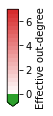

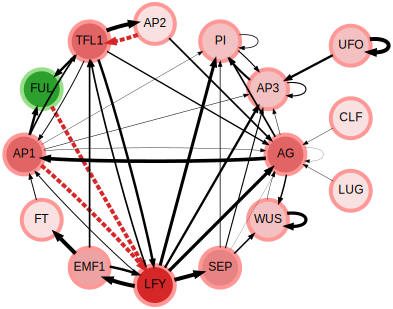

In [ ]:
pEG = graphviz.Digraph(name='Effective Graph', engine='neato')
pEG.attr('graph', size='6,6', concentrate='false', simplify='false', overlap='false',splines='false',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_outdegree = max([v for n,v in EG0.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG0.nodes(data=True)]

min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
cmap.set_under('#2ca02c')
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=10**-16, vmax=max_outdegree)
# Plot Colorbar
fig = plt.figure(figsize=(.75,1.5))
ax = fig.add_axes([0.1, 0.05, 0.21, 0.9])
ticks = [0,2,4,6,8]
boundaries = np.linspace(-1, max_outdegree,25).tolist()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
                               ticks=ticks,spacing='uniform', orientation='vertical',
                               extend='min', format='%.0f')
cb.set_label('Effective out-degree')

display(fig)
#plt.savefig('colorbar.pdf', transparent=True)
plt.close()
#
for nid,d in EG.nodes(data=True):
    dEG0 = EG0.nodes[nid]
    snid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    out_degree = EG0.out_degree(nid, weight='weight')
    if out_degree == 0:
        color = '#98df8a'
        fillcolor = '#2ca02c'
    else:
        rgb = cmap(norm(EG0.out_degree(nid, weight='weigth')))
        hex = mpl.colors.rgb2hex(rgb)
        color = '#ff9896'
        fillcolor = hex
    pEG.node(snid, label=label, pos=pos, color=color, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight'] * max_penwidth )
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid,vid, style='dashed', color='#d62728')
    
# Export
display(pEG)
#pEG.render("Thaliana-EG", cleanup=True)

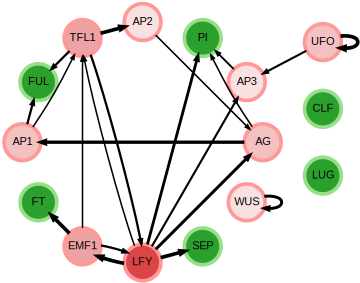

In [ ]:
pEG = graphviz.Digraph(name='Effective Graph', engine='neato')
pEG.attr('graph', size='5,5', concentrate='false', simplify='false', overlap='false',splines='true',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')


# Plot Graph
for nid,d in EG.nodes(data=True):
    snid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    out_degree = EG0p4.out_degree(nid, weight='weight')
    if out_degree == 0:
        color='#98df8a'
        fillcolor = '#2ca02c'
    else:
        rgb = cmap(norm(EG0p4.out_degree(nid, weight='weigth')))
        hex = mpl.colors.rgb2hex(rgb)
        color = '#ff9896'
        fillcolor = hex
    pEG.node(snid, label=label, pos=pos, color=color, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight'] * max_penwidth )
    if d['weight'] >= 0.4:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        #pEG.edge(uid,vid, style='dashed', color='#d62728')
        pass

# Export
display(pEG)
#pEG.render("Thaliana-EGt0p4", cleanup=True)